In [80]:
import os
os.environ['HF_HOME'] = '/scr/jshen3/.cache/huggingface'
os.environ['HF_HUB'] = '/scr/jshen3/.cache/huggingface'
from dotenv import load_dotenv
load_dotenv()

from huggingface_hub import login
login(os.getenv('HF_KEY'))

openai_api_key = os.getenv('OPENAI_API_KEY')


import warnings
warnings.filterwarnings("ignore")
import re
import torch
from transformers import AutoTokenizer
import os
import openai
from openai import OpenAI
from difflib import SequenceMatcher
import pandas as pd
import numpy as np

# Function to calculate similarity
def calculate_similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

openai_client = OpenAI(api_key=openai_api_key)
QUESTION = ""
SYSTEM_PROMPT = "You are a skilled mathematical reasoner who can identify the steps in an answer to a problem and provide concise, specific, and descriptive natural language labels for each step."

INITIAL_QUESTION_PROMPT = f"""I will give you a math problem and a model-generated solution to the problem. Categorize the solution into steps using descriptive, specific, and concise natural language labels.   
You should return the steps, in order, separated by commas in one single line. The goal is to call output.split(", ") on the output you generate. 

Question: {QUESTION}
Answer:
"""

TEMP_PROMPT = f"""
You will be given some text (an answer to a mathematical problem, consisting of multiple logical sub-steps and a final answer). Your task is to split this answer into a sequence of logical steps (as many as you see fit, there is no strict lower bound or upper bound on the number of acceptable steps). You are provided with three expert-annotated examples that take in text and split it into a sequence of logical steps. Make the sentence that clearly states the answer its own step (this should be the final step). Pay no attention to the correctness or validity of the answer. Similar to the examples above, separate each of the splitted steps using <STEP SPLIT>. The goal is to call output.split("<STEP SPLIT>") on the output you generate. 

Input 1:
  A: First, lets calculate the regular 
 hours Tina works in a week:\n
 \n
 Regular hours per week = Hours per day * Days per week\n
 Regular hours per week = 10 hours * 5 days\n
 Regular hours per week = 50 hours\n
 \n
 Next, well determine the amount Tina earns for her regular hours:\n
 \n
 Regular wage = Hourly wage * Regular hours per week\n
 Regular wage = $18.00/hour * 50 hours\n
 Regular wage = $900.00\n
 \n
 Now well calculate the number of overtime hours Tina works in a week:\n
 \n
 Overtime hours per week = Total hours per week - Regular hours per week\n
 Overtime hours per week = 50 hours - 40 hours (8 hours/day * 5 days)\n
 Overtime hours per week = 10 hours\n
 \n
 Next, well determine the amount Tina earns for her overtime hours:\n
 \n
 Overtime wage = Hourly wage * Overtime hours per week + Hourly wage * 
 Overtime hours per week (half)\n
 Overtime wage = $18.00/hour * 10 hours + $18.00/hour * 5 hours\n
 Overtime wage = $189.00 + $90.00\n
 Overtime wage = $279.00\n
 \n
 Finally, we add Tinas regular wage and overtime wage to find her total 
 earnings for the week:\n
 \n
 Total earnings per week = Regular wage + Overtime wage\n
 Total earnings per week = $900.00 + $279.00\n
 Total earnings per week = $1,179.00\n
 \n
 So, Tina makes a total of $1,179.00 in a week when she works 10 hours every 
 day for 5 

Output 1:

 First, lets calculate the regular 
 hours Tina works in a week:\n
 \n
 Regular hours per week = Hours per day * Days per week\n
 Regular hours per week = 10 hours * 5 days\n
 Regular hours per week = 50 hours\n
 \n
<STEP SPLIT>
 Next, well determine the amount Tina earns for her regular hours:\n
 \n
 Regular wage = Hourly wage * Regular hours per week\n
 Regular wage = $18.00/hour * 50 hours\n
 Regular wage = $900.00\n
 \n
<STEP SPLIT>
 Now well calculate the number of overtime hours Tina works in a week:\n
 \n
 Overtime hours per week = Total hours per week - Regular hours per week\n
 Overtime hours per week = 50 hours - 40 hours (8 hours/day * 5 days)\n
 Overtime hours per week = 10 hours\n
 \n
<STEP SPLIT>
 Next, well determine the amount Tina earns for her overtime hours:\n
 \n
 Overtime wage = Hourly wage * Overtime hours per week + Hourly wage * 
 Overtime hours per week (half)\n
 Overtime wage = $18.00/hour * 10 hours + $18.00/hour * 5 hours\n
 Overtime wage = $189.00 + $90.00\n
 Overtime wage = $279.00\n
 \n
<STEP SPLIT>
 Finally, we add Tinas regular wage and overtime wage to find her total 
 earnings for the week:\n
 \n
 Total earnings per week = Regular wage + Overtime wage\n
 Total earnings per week = $900.00 + $279.00\n
 Total earnings per week = $1,179.00\n
 \n
<STEP SPLIT>
 So, Tina makes a total of $1,179.00 in a week when she works 10 hours every 
 day for 5 
 days.


Input 2:
 We know that Randy has 60 mango 
 trees.\n
 He has 5 less than half as many coconut trees as mango trees.\n
 Half of 60 mango trees is 30, so Randy has 5 fewer, which is 25 less. So 
 he has 30 * 2 = 60 coconut trees.\n
 Therefore, Randy has a total of 60 mango trees + 60 coconut trees = 120 
 trees on his 

Output 2:

 We know that Randy has 60 mango 
 Trees.\n
<STEP SPLIT>
 He has 5 less than half as many coconut trees as mango trees.\n
<STEP SPLIT>
 Half of 60 mango trees is 30, so Randy has 5 fewer, which is 25 less. So 
 he has 30 * 2 = 60 coconut trees.\n
<STEP SPLIT>
 Therefore, Randy has a total of 60 mango trees + 60 coconut trees = 120 
 trees on his 


Input 3:
First, lets determine how many pages 
 Joy reads in one minute: \n
 Pages read per minute = Pages read per 20 minutes / 20 minutes\n
 = 8 pages / 20 minutes \n
 = 0.4 pages per minute\n
 \n
 Next, well find out how long it takes Joy to read 120 pages:\n
 Time = Pages to be read / Pages read per minute\n
 = 120 pages / 0.4 pages per minute\n
 = 300 minutes\n
 \n
 Finally, well convert 300 minutes into hours:\n
 Hours = Minutes / 60\n
 = 300 minutes / 60\n
 = 5 hours.\n
 \n
 So it will take Joy 5 hours to read 120 
 pages.

Output 3:

First, lets determine how many pages 
 Joy reads in one minute: \n
 Pages read per minute = Pages read per 20 minutes / 20 minutes\n
 = 8 pages / 20 minutes \n
 = 0.4 pages per minute\n
 \n
<STEP SPLIT>
 Next, well find out how long it takes Joy to read 120 pages:\n
 Time = Pages to be read / Pages read per minute\n
 = 120 pages / 0.4 pages per minute\n
 = 300 minutes\n
 \n
<STEP SPLIT>
 Finally, well convert 300 minutes into hours:\n
 Hours = Minutes / 60\n
 = 300 minutes / 60\n
 = 5 hours.\n
 \n
<STEP SPLIT>
 So it will take Joy 5 hours to read 120 
 pages.


Input 4:
{QUESTION}

Output 4:

"""

# TEMP_PROMPT = f"""I will give you a math problem and a model-generated solution to the problem. Your task is to identify where in the solution distinct steps occur, and to separate the solution at the location of each step with <STEP SPLIT>.
# You should return the steps, in order, separated by <STEP SPLIT> in one single line. The goal is to call output.split("<STEP SPLIT>") on the output you generate. 
# If I concatenate the steps you provide, they should be identical to the original solution.

# Question: {QUESTION}
# Answer:
# """

model_name = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /scr/jshen3/.cache/huggingface/token
Login successful


In [39]:
def callGPT(outputs):
    completion = openai_client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": f"{TEMP_PROMPT} {outputs}"}
            ],
            temperature = 0
        )

    data = completion.choices[0].message.content.strip()
    return data

def computeStepSurprisal(list_output, log_tensor, tensor):
    best_matches = []
    # have to assert that joining them is equal to the original output. 
    for step_var in list_output:
        token_length = len(tokenizer.encode(step_var)) - 1 # subtract 1 for the <s> token
        
        best_similarity = 0
        best_index = -1

        found = False
        for start_index in range(1, len(tensor) - token_length):
            decoded_segment = tokenizer.decode(tensor[start_index : start_index + token_length])
            similarity = calculate_similarity(decoded_segment, step_var)
            if similarity > best_similarity:
                best_similarity = similarity
                best_index = start_index
            

        if best_index != -1:
            best_matches.append((step_var, best_index, best_index + token_length, best_similarity))
    stepSurprisals = []
    normalizedSurprisals = []
    for step_var, index, end_index, similarity in best_matches:
        if index is not None:
            # print(f"Best match for step '{step_var}' is {tokenizer.decode(tensor[0][index : end_index])} found at index {index} with similarity {similarity:.2f}")
            # print(round(similarity, 2))
            # print(index, end_index)
            # decoded_segment = tokenizer.decode(tensor[index : end_index])
            # print('Step: ', step_var)
            # print('Decoded: ', decoded_segment)
            surprisal = -torch.sum(log_tensor[index-1 : end_index-1]).item()
            normalized_surprisal = -torch.mean(log_tensor[index-1 : end_index-1]).item()

            stepSurprisals.append(surprisal)
            normalizedSurprisals.append(normalized_surprisal)

        else:
            print(f"Failed to find a close match for step '{step_var}'")
    return stepSurprisals, normalizedSurprisals
def topK(tensor, k=10):
    # Flatten the tensor
    flat_tensor = tensor.flatten()
    # Compute the number of top elements to select
    num_top_elements = int(np.ceil(k / 100 * len(flat_tensor)))
    # Get the top k percent elements
    top_elements = np.sort(flat_tensor)[-num_top_elements:]
    return top_elements
def computeTokenStats(curr_output, log_tensor, tensor):
    # print(curr_output)
    # return
    token_length = len(tokenizer.encode(curr_output)) - 1
    # print(tokens)
    # len(tokenizer.encode(step_var))
    surprisalTensor = -log_tensor
    found = False
    best_index = -1
    best_matches = None
    best_similarity = 0
    for start_index in range(len(tensor)):
        decoded_segment = tokenizer.decode(tensor[start_index : start_index + token_length])
        similarity = calculate_similarity(decoded_segment, curr_output)
        if similarity > best_similarity:
            best_similarity = similarity
            best_index = start_index
    if best_index != -1:
            best_matches = (best_index, best_index + token_length, best_similarity)
    index, end_index, similarity = best_matches
    newSurprisalTensor = np.array(-log_tensor[index: end_index])
    mean = np.mean(newSurprisalTensor)
    max = np.max(newSurprisalTensor)
    topk = np.mean(topK(newSurprisalTensor))
    sum_ = np.sum(newSurprisalTensor)
    
    return mean, max, topk, sum_, newSurprisalTensor
    
def extractSentence(text):
    sentence_pattern = r'([A-Z][^.!?]*[.!?])'


    # Find all sentences
    sentences = re.findall(sentence_pattern, text)

    # Get the last sentence
    if sentences:
        last_sentence = sentences[-1]
    else:
        last_sentence = None
    return last_sentence
    

In [68]:
fit_df = pd.read_csv('data/fit_df.csv')
fit_df

,Question,Problem,Sample,Answer,Step,Raw Data,prevMax,prevMean,prevSum,y
0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0,"\n\nTherefore, Janet makes $18 every day at th...",2,"[41.05207443237305, 41.53960037231445]",41.539600,41.295837,82.591675,NaN
1,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0,"\n\nTherefore, Janet makes $18 every day at th...",3,"[41.05207443237305, 41.53960037231445, 18.0696...",41.539600,33.553762,100.661287,NaN
2,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0,"\n\nTherefore, Janet makes $18 every day at th...",4,"[41.05207443237305, 41.53960037231445, 18.0696...",41.539600,32.240077,128.960310,NaN
3,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,1,"\n So, Janet makes $18 every day at the farmer...",2,"[13.467633247375488, 15.452184677124023]",15.452185,14.459909,28.919818,NaN
4,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,1,"\n So, Janet makes $18 every day at the farmer...",3,"[13.467633247375488, 15.452184677124023, 11.92...",15.452185,13.615336,40.846009,NaN
...,...,...,...,...,...,...,...,...,...,...
1715,[INST] Q: I have 10 liters of orange drink tha...,20,11,\nSince we spilled one liter of the orange dri...,2,"[57.985931396484375, 21.482593536376953]",57.985931,39.734262,79.468525,NaN
1716,[INST] Q: I have 10 liters of orange drink tha...,20,12,"\n Therefore, there are 5.33 liters of water i...",2,"[30.104389190673828, 25.64190673828125]",30.104389,27.873148,55.746296,NaN
1717,[INST] Q: I have 10 liters of orange drink tha...,20,12,"\n Therefore, there are 5.33 liters of water i...",3,"[30.104389190673828, 25.64190673828125, 4.9983...",30.104389,20.248221,60.744664,NaN
1718,[INST] Q: I have 10 liters of orange drink tha...,20,12,"\n Therefore, there are 5.33 liters of water i...",4,"[30.104389190673828, 25.64190673828125, 4.9983...",30.104389,17.638922,70.555689,NaN


In [26]:
log_df = pd.DataFrame(columns=['Question', 'Problem', 'mean', 'max', 'top10_mean', 'sum', 'surprisal_tensor', 'answer', 'y'])
fit_df = pd.DataFrame(columns=['Question', 'Problem', 'Sample', 'Answer', 'Step', 'Raw Data', 'prevMax', 'prevMean', 'prevSum', 'y'])

In [40]:
for q in range(100):
    print(f'Problem {q}')
    # QUESTION_START = "[INST] Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?\nA: Let's think step by step. [/INST] "
    base_path = f"mistral-7b-v0.1-samples25-fewshot0-temp0.7-topk40-CoT-gsm8k_p{q}.pt"
    log_path = "other_logprob_tensors/" + base_path + "-logprobs.pt"
    FILE_PATH = "tensors/" + base_path
    tok_tensor = torch.load(FILE_PATH, map_location="cpu") # Load the file into a tensor
    log_tensor = torch.load(log_path, map_location="cpu") # Load the file into a tensor
    decoded_output = tokenizer.batch_decode(tok_tensor)
    response = " ".join(decoded_output)
    # print(len(response))
    # print(response)
    match_with_tokens = re.search(r'(\[INST\].*?\[/INST\])', decoded_output[0], re.DOTALL)
    QUESTION_START = match_with_tokens.group(1).strip() + ' ' if match_with_tokens else None
    parsed_outputs = response.split(QUESTION_START)[1:]
    stripped_outputs = [output.replace("<s>", "").replace("</s>", "").strip() for output in parsed_outputs] # Remove <s> tokens from the list of outputs
    for i in range(25):
        try:
            list_output = stripped_outputs[i]
            answer = extractSentence(list_output)
            
            mean, max, topk, sum_, newSurprisalTensor = computeTokenStats(list_output, log_tensor[i], tok_tensor[i])
            # print(tokenizer.decode(tok_tensor[i]))
            # print('Raw Step Surprisals: ', stepSurprisals)
            # print('Normed Step Surprisals: ', normSurprisals)
            new_log_df = pd.DataFrame([{'Question': QUESTION_START, 'Problem': q,
                                        'mean': mean, 'max': max, 'top10_mean': topk, 'sum': sum_, 'surprisal_tensor': newSurprisalTensor, 'answer': answer, 'y': None}])
            log_df = pd.concat([log_df, new_log_df], ignore_index=True)

        except Exception as e:
            print(f"Error processing question{q}, sample {i}: {e}")
    print()

Problem 0

Problem 1

Problem 2

Problem 3

Problem 4

Problem 5

Problem 6

Problem 7

Problem 8

Problem 9

Problem 10

Problem 11

Problem 12

Problem 13

Problem 14

Problem 15

Problem 16

Problem 17

Problem 18

Problem 19

Problem 20

Problem 21

Problem 22

Problem 23

Problem 24

Problem 25

Problem 26

Problem 27

Problem 28

Problem 29

Problem 30

Problem 31

Problem 32

Problem 33

Problem 34

Problem 35

Problem 36

Problem 37

Problem 38

Problem 39

Problem 40

Problem 41

Problem 42

Problem 43

Problem 44

Problem 45

Problem 46

Problem 47

Problem 48

Problem 49

Problem 50

Problem 51

Problem 52

Problem 53

Problem 54

Problem 55

Problem 56

Problem 57

Problem 58

Problem 59

Problem 60

Problem 61

Problem 62

Problem 63

Problem 64

Problem 65

Problem 66

Problem 67

Problem 68

Problem 69

Problem 70

Problem 71

Problem 72

Problem 73

Problem 74

Problem 75

Problem 76

Problem 77

Problem 78

Problem 79

Problem 80

Problem 81

Problem 82

Problem 83

Pr

In [65]:
log_df.rename(columns={'answer': 'Answer'}, inplace=True)
log_df.to_csv('data/token_surprisal.csv', index=False)
# log_df['y'] = gsm
log_df.head()

,Question,Problem,mean,max,top10_mean,sum,surprisal_tensor,Answer,y
0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.769928,10.067566,3.752856,113.179352,"[0.48498946, 0.7112749, 3.3107986, 0.4158175, ...","Therefore, Janet makes $18 every day at the fa...",None
1,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.646181,4.717769,2.829752,68.495171,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","So, Janet makes $18 every day at the farmers' ...",None
2,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.673332,5.155902,3.287354,72.719833,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","Therefore, Janet makes $18 every day at the fa...",None
3,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.463329,4.550774,2.477553,71.815941,"[0.6362972, 0.0011935261, 1.4767748, 0.0608319...","Therefore, Janet makes $18 every day at the fa...",None
4,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.657644,5.404667,3.111100,78.259636,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","To find out how much money she makes, we multi...",None


In [23]:
gsm8k = pd.read_csv('data/gsm8kTest.csv')

gsm8k.head()

,index,question,answer,AnswerNum
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0
1,1,A robe takes 2 bolts of blue fiber and half th...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...,3.0
2,2,Josh decides to try flipping a house. He buys...,The cost of the house and repairs came out to ...,70000.0
3,3,James decides to run 3 sprints 3 times a week....,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...,540.0
4,4,"Every day, Wendi feeds each of her chickens th...","If each chicken eats 3 cups of feed per day, t...",20.0


In [46]:
cot_merged = pd.merge(gsm8k, log_df, left_on='index', right_on='Problem', how='inner')
# cot_merged = pd.merge(cot_merged, currDirectDF, left_on='index', right_on='Problem', how='inner')
# cot_merged.rename(columns={"entropy_x": "CoT Entropy", "entropy_y": "Direct Entropy", 
#                            'normalized_entropy_x': 'Normalized CoT Entropy', 'normalized_entropy_y': 'Normalized Direct Entropy',
#                            'top_k_entropy_x': 'TopK CoT Entropy', 'top_k_entropy_y': 'TopK Direct Entropy'}, inplace=True)
cot_merged

,index,question,answer,AnswerNum,Question,Problem,mean,max,top10_mean,sum,surprisal_tensor,Answer,y
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.769928,10.067566,3.752856,113.179352,"[0.48498946, 0.7112749, 3.3107986, 0.4158175, ...","Therefore, Janet makes $18 every day at the fa...",None
1,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.646181,4.717769,2.829752,68.495171,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","So, Janet makes $18 every day at the farmers' ...",None
2,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.673332,5.155902,3.287354,72.719833,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","Therefore, Janet makes $18 every day at the fa...",None
3,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.463329,4.550774,2.477553,71.815941,"[0.6362972, 0.0011935261, 1.4767748, 0.0608319...","Therefore, Janet makes $18 every day at the fa...",None
4,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.657644,5.404667,3.111100,78.259636,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","To find out how much money she makes, we multi...",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.588797,5.294690,2.927899,102.450729,"[0.32926095, 2.0481815, 0.111291006, 0.0002200...","First, let's calculate how many potted plants ...",None
2496,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.631540,14.674966,3.918477,85.257889,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....","After giving away these 40 potted plants, Mary...",None
2497,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.498792,7.565978,2.741107,64.344124,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....",Final answer: Mary will remain with 40 potted ...,None
2498,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.679994,3.880364,2.805673,36.719666,"[3.2316728, 0.20105334, 0.21169637, 1.3998772,...","After giving away 1 plant from each ledge, she...",None


In [48]:
import re

def extractAnswers(sentences):
    last_numbers = []
    for sentence in sentences:
        # Improved regex to correctly capture numbers with commas
        numbers = re.findall(r'\b\d{1,3}(?:,\d{3})*\b', sentence)
        # Remove commas and convert to integers
        numbers = [int(num.replace(',', '')) for num in numbers]
        if numbers:
            return numbers

            
cot_merged['MistralAnswersCoT'] = None
# cot_merged['MistralAnswersDirect'] = None

for idx, row in cot_merged.iterrows():
    answer = row['Answer']
    # last_numbers = []
    # for answer in answers:
    if answer:
        numbers = re.findall(r'\b\d{1,3}(?:,\d{3})*\b', answer)
        numbers = [int(num.replace(',', '')) for num in numbers]
        # if numbers:
        #     last_numbers.append(numbers)
        cot_merged.at[idx, 'MistralAnswersCoT'] = numbers

# for idx, row in cot_merged.iterrows():
#     answers = row['answer_statements_y']
#     last_numbers = []
#     for answer in answers:
#         numbers = re.findall(r'\b\d{1,3}(?:,\d{3})*\b', answer)
#         numbers = [int(num.replace(',', '')) for num in numbers]
#         if numbers:
#             last_numbers.append(numbers)
#     cot_merged.at[idx, 'MistralAnswersDirect'] = last_numbers


cot_merged

,index,question,answer,AnswerNum,Question,Problem,mean,max,top10_mean,sum,surprisal_tensor,Answer,y,MistralAnswersCoT
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.769928,10.067566,3.752856,113.179352,"[0.48498946, 0.7112749, 3.3107986, 0.4158175, ...","Therefore, Janet makes $18 every day at the fa...",None,[18]
1,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.646181,4.717769,2.829752,68.495171,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","So, Janet makes $18 every day at the farmers' ...",None,[18]
2,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.673332,5.155902,3.287354,72.719833,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","Therefore, Janet makes $18 every day at the fa...",None,[18]
3,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.463329,4.550774,2.477553,71.815941,"[0.6362972, 0.0011935261, 1.4767748, 0.0608319...","Therefore, Janet makes $18 every day at the fa...",None,[18]
4,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18.0,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.657644,5.404667,3.111100,78.259636,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","To find out how much money she makes, we multi...",None,"[2, 9, 18, 18]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.588797,5.294690,2.927899,102.450729,"[0.32926095, 2.0481815, 0.111291006, 0.0002200...","First, let's calculate how many potted plants ...",None,"[2, 40, 80, 1, 40, 40, 80, 40, 40, 40, 1]"
2496,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.631540,14.674966,3.918477,85.257889,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....","After giving away these 40 potted plants, Mary...",None,"[40, 80, 40, 80, 40, 40, 40]"
2497,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.498792,7.565978,2.741107,64.344124,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....",Final answer: Mary will remain with 40 potted ...,None,[40]
2498,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58.0,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.679994,3.880364,2.805673,36.719666,"[3.2316728, 0.20105334, 0.21169637, 1.3998772,...","After giving away 1 plant from each ledge, she...",None,"[1, 40, 40, 0, 0]"


In [51]:
cot_merged['AnswerNum'] = cot_merged['AnswerNum'].astype(int)
cot_merged = cot_merged.dropna(subset=['MistralAnswersCoT'])
cot_merged

,index,question,answer,AnswerNum,Question,Problem,mean,max,top10_mean,sum,surprisal_tensor,Answer,y,MistralAnswersCoT
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.769928,10.067566,3.752856,113.179352,"[0.48498946, 0.7112749, 3.3107986, 0.4158175, ...","Therefore, Janet makes $18 every day at the fa...",1,[18]
1,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.646181,4.717769,2.829752,68.495171,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","So, Janet makes $18 every day at the farmers' ...",1,[18]
2,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.673332,5.155902,3.287354,72.719833,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","Therefore, Janet makes $18 every day at the fa...",1,[18]
3,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.463329,4.550774,2.477553,71.815941,"[0.6362972, 0.0011935261, 1.4767748, 0.0608319...","Therefore, Janet makes $18 every day at the fa...",1,[18]
4,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.657644,5.404667,3.111100,78.259636,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","To find out how much money she makes, we multi...",1,"[2, 9, 18, 18]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.588797,5.294690,2.927899,102.450729,"[0.32926095, 2.0481815, 0.111291006, 0.0002200...","First, let's calculate how many potted plants ...",None,"[2, 40, 80, 1, 40, 40, 80, 40, 40, 40, 1]"
2496,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.631540,14.674966,3.918477,85.257889,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....","After giving away these 40 potted plants, Mary...",None,"[40, 80, 40, 80, 40, 40, 40]"
2497,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.498792,7.565978,2.741107,64.344124,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....",Final answer: Mary will remain with 40 potted ...,None,[40]
2498,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.679994,3.880364,2.805673,36.719666,"[3.2316728, 0.20105334, 0.21169637, 1.3998772,...","After giving away 1 plant from each ledge, she...",None,"[1, 40, 40, 0, 0]"


In [53]:
# cot_merged['MistralAccCoT'] = None
# cot_merged['MistralAccDirect'] = None

for idx, row in cot_merged.iterrows():
    cot_nums = 0
    cot_total = 25
    cot_answers = row['MistralAnswersCoT']
    # direct_answers = row['MistralAnswersDirect']

    groundTruth = row['AnswerNum']
    # for ans in cot_answers:
    if groundTruth in cot_answers:
        cot_merged.at[idx, 'y'] = 1
    else:
        cot_merged.at[idx, 'y'] = 0
      
cot_merged
            

,index,question,answer,AnswerNum,Question,Problem,mean,max,top10_mean,sum,surprisal_tensor,Answer,y,MistralAnswersCoT
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.769928,10.067566,3.752856,113.179352,"[0.48498946, 0.7112749, 3.3107986, 0.4158175, ...","Therefore, Janet makes $18 every day at the fa...",1,[18]
1,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.646181,4.717769,2.829752,68.495171,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","So, Janet makes $18 every day at the farmers' ...",1,[18]
2,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.673332,5.155902,3.287354,72.719833,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","Therefore, Janet makes $18 every day at the fa...",1,[18]
3,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.463329,4.550774,2.477553,71.815941,"[0.6362972, 0.0011935261, 1.4767748, 0.0608319...","Therefore, Janet makes $18 every day at the fa...",1,[18]
4,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.657644,5.404667,3.111100,78.259636,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","To find out how much money she makes, we multi...",1,"[2, 9, 18, 18]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.588797,5.294690,2.927899,102.450729,"[0.32926095, 2.0481815, 0.111291006, 0.0002200...","First, let's calculate how many potted plants ...",0,"[2, 40, 80, 1, 40, 40, 80, 40, 40, 40, 1]"
2496,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.631540,14.674966,3.918477,85.257889,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....","After giving away these 40 potted plants, Mary...",0,"[40, 80, 40, 80, 40, 40, 40]"
2497,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.498792,7.565978,2.741107,64.344124,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....",Final answer: Mary will remain with 40 potted ...,0,[40]
2498,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.679994,3.880364,2.805673,36.719666,"[3.2316728, 0.20105334, 0.21169637, 1.3998772,...","After giving away 1 plant from each ledge, she...",0,"[1, 40, 40, 0, 0]"


In [24]:
cot_merged['y'].sum()

686

In [25]:
cot_merged

,index,question,answer,AnswerNum,Question,Problem,Sample,Answer,Step,Raw Data,prevMax,prevMean,prevSum,y,MistralAnswersCoT
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0,"\n\nTherefore, Janet makes $18 every day at th...",2,"[41.05207443237305, 41.53960037231445]",41.539600,41.295837,82.591675,1,[18]
1,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0,"\n\nTherefore, Janet makes $18 every day at th...",3,"[41.05207443237305, 41.53960037231445, 18.0696...",41.539600,33.553762,100.661287,1,[18]
2,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0,"\n\nTherefore, Janet makes $18 every day at th...",4,"[41.05207443237305, 41.53960037231445, 18.0696...",41.539600,32.240077,128.960310,1,[18]
3,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,1,"\n So, Janet makes $18 every day at the farmer...",2,"[13.467633247375488, 15.452184677124023]",15.452185,14.459909,28.919818,1,[18]
4,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,1,"\n So, Janet makes $18 every day at the farmer...",3,"[13.467633247375488, 15.452184677124023, 11.92...",15.452185,13.615336,40.846009,1,[18]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,20,I have 10 liters of orange drink that are two-...,There are 15 x 3/5 = <<15*3/5=9>>9 liters of w...,15,[INST] Q: I have 10 liters of orange drink tha...,20,11,\nSince we spilled one liter of the orange dri...,2,"[57.985931396484375, 21.482593536376953]",57.985931,39.734262,79.468525,0,"[24, 12, 33, 1, 11, 33, 24]"
1716,20,I have 10 liters of orange drink that are two-...,There are 15 x 3/5 = <<15*3/5=9>>9 liters of w...,15,[INST] Q: I have 10 liters of orange drink tha...,20,12,"\n Therefore, there are 5.33 liters of water i...",2,"[30.104389190673828, 25.64190673828125]",30.104389,27.873148,55.746296,0,"[5, 33, 24]"
1717,20,I have 10 liters of orange drink that are two-...,There are 15 x 3/5 = <<15*3/5=9>>9 liters of w...,15,[INST] Q: I have 10 liters of orange drink tha...,20,12,"\n Therefore, there are 5.33 liters of water i...",3,"[30.104389190673828, 25.64190673828125, 4.9983...",30.104389,20.248221,60.744664,0,"[5, 33, 24]"
1718,20,I have 10 liters of orange drink that are two-...,There are 15 x 3/5 = <<15*3/5=9>>9 liters of w...,15,[INST] Q: I have 10 liters of orange drink tha...,20,12,"\n Therefore, there are 5.33 liters of water i...",4,"[30.104389190673828, 25.64190673828125, 4.9983...",30.104389,17.638922,70.555689,0,"[5, 33, 24]"


In [120]:
surp = pd.DataFrame(columns = ['Problem', 'prevMeanStd', 'prevMaxStd', 'Accuracy'])

grouped = cot_merged.groupby(['index', 'Sample']).agg({
    'prevMax': 'mean',
    'prevMean': 'mean',
    'y': 'mean'
})
grouped.reset_index(level='Sample', inplace=True)
# grouped.iloc[50:75]
grouped = grouped.groupby('index').agg({
    'prevMax': 'std',
    'prevMean': 'std',
    'y': 'mean'
})
grouped.rename(columns = {'prevMax': 'prevMaxStd', 'prevMean': 'prevMeanStd', 'y': 'Accuracy'}, inplace=True)
groupedFilt = grouped[(grouped['Accuracy'] > 0.1) & (grouped['Accuracy'] < 0.9)]
groupedFilt.reset_index()
# for name, group in grouped:
#     print(f"Group: {name}", len(group))
#     df = group
#     break
#     new_surp_df = pd.DataFrame([{'Problem': name, 'prevMeanStd': df['prevMean'].std(), 
#                                 'prevMaxStd': df['prevMax'].std(), 'Accuracy': df['y'].sum()/len(df)}])
#     surp = pd.concat([surp, new_surp_df], ignore_index=True)

,prevMaxStd,prevMeanStd,Accuracy
index,,,
1,8.334535,6.433688,0.750000
2,108.253635,53.767709,0.120000
4,12.468864,9.668208,0.440000
5,12.901728,11.242805,0.280000
6,15.207907,10.113571,0.440000
9,9.225941,5.873034,0.480000
14,11.999033,6.063745,0.480000
15,20.418639,10.130382,0.200000
16,16.649521,15.367431,0.760000


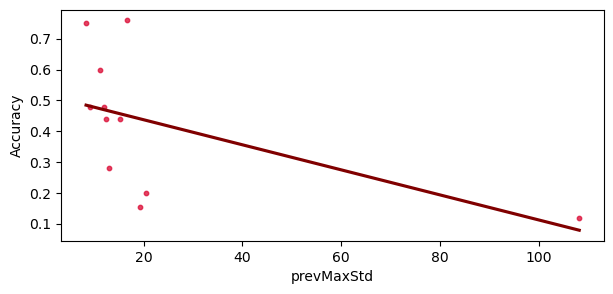

In [124]:
plt.figure(figsize=(7, 3))
X = sm.add_constant(x1)
lm = sm.OLS(y, X).fit()
intercept, slope = lm.params
axs = sns.regplot(x='prevMaxStd', y='Accuracy', data=groupedFilt, ci=0,
                 scatter_kws={"color": "crimson", "s": 10},  # scatter_kws for scatter points
                 line_kws={"color": "maroon", "label": f'y = {slope:.2f}x + {intercept:.2f}'})  # line_kws for line

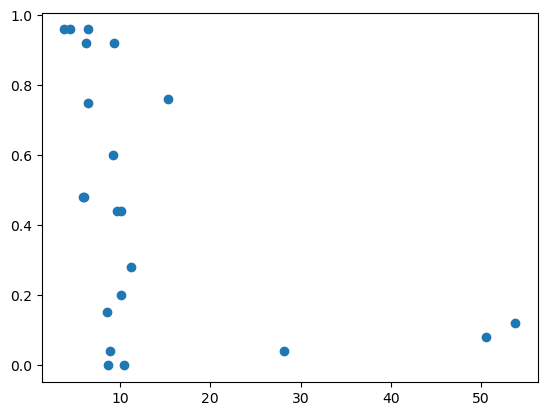

In [99]:
plt.scatter(grouped['prevMeanStd'], grouped['Accuracy'])

In [96]:
grouped.corr()

,prevMaxStd,prevMeanStd,Accuracy
prevMaxStd,1.000000,0.978777,-0.512319
prevMeanStd,0.978777,1.000000,-0.462250
Accuracy,-0.512319,-0.462250,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

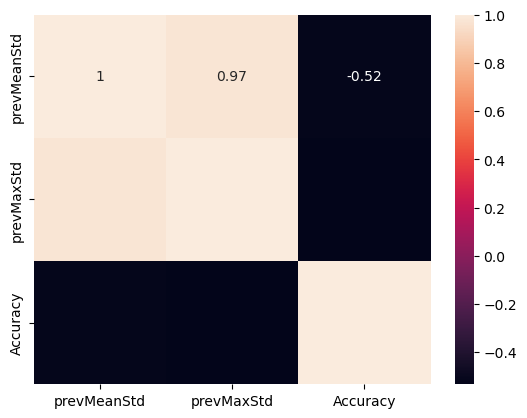

In [69]:
import seaborn as sns
cor = surp[['prevMeanStd', 'prevMaxStd', 'Accuracy']]
sns.heatmap(cor.corr(), annot=True)
plt.show

In [27]:
len(x1)

NameError: name 'x1' is not defined

In [72]:
df = cot_merged.apply(pd.to_numeric, errors='coerce')
df = df[['top10_mean', 'y']]
x1 = df[f'top10_mean']
y = df['y']
# df.drop_duplicates(inplace=True)
df

,top10_mean,y
0,3.752856,1
1,2.829752,1
2,3.287354,1
3,2.477553,1
4,3.111100,1
...,...,...
2495,2.927899,0
2496,3.918477,0
2497,2.741107,0
2498,2.805673,0


Text(0.5, 0, 'Top 10% Surprisal Mean')

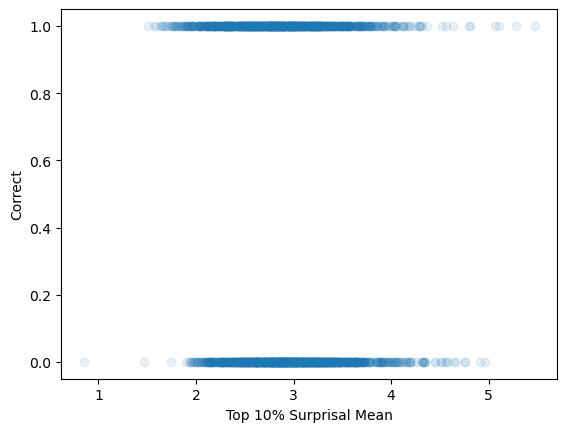

In [76]:
import matplotlib.pyplot as plt
plt.scatter(x1, y, alpha = 0.1)
plt.ylabel('Correct')
plt.xlabel('Top 10% Surprisal Mean')

In [59]:
cot_merged

,index,question,answer,AnswerNum,Question,Problem,mean,max,top10_mean,sum,surprisal_tensor,Answer,y,MistralAnswersCoT
0,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.769928,10.067566,3.752856,113.179352,"[0.48498946, 0.7112749, 3.3107986, 0.4158175, ...","Therefore, Janet makes $18 every day at the fa...",1,[18]
1,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.646181,4.717769,2.829752,68.495171,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","So, Janet makes $18 every day at the farmers' ...",1,[18]
2,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.673332,5.155902,3.287354,72.719833,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","Therefore, Janet makes $18 every day at the fa...",1,[18]
3,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.463329,4.550774,2.477553,71.815941,"[0.6362972, 0.0011935261, 1.4767748, 0.0608319...","Therefore, Janet makes $18 every day at the fa...",1,[18]
4,0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,[INST] Q: Janet’s ducks lay 16 eggs per day. S...,0,0.657644,5.404667,3.111100,78.259636,"[0.003942219, 4.717769, 0.27462688, 0.19879402...","To find out how much money she makes, we multi...",1,"[2, 9, 18, 18]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.588797,5.294690,2.927899,102.450729,"[0.32926095, 2.0481815, 0.111291006, 0.0002200...","First, let's calculate how many potted plants ...",0,"[2, 40, 80, 1, 40, 40, 80, 40, 40, 40, 1]"
2496,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.631540,14.674966,3.918477,85.257889,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....","After giving away these 40 potted plants, Mary...",0,"[40, 80, 40, 80, 40, 40, 40]"
2497,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.498792,7.565978,2.741107,64.344124,"[0.5174688, 0.5695008, 1.1169522, 1.059663, 0....",Final answer: Mary will remain with 40 potted ...,0,[40]
2498,99,"Mary is an avid gardener. Yesterday, she recei...","Yesterday, before receiving the plants, Mary h...",58,"[INST] Q: Mary is an avid gardener. Yesterday,...",99,0.679994,3.880364,2.805673,36.719666,"[3.2316728, 0.20105334, 0.21169637, 1.3998772,...","After giving away 1 plant from each ledge, she...",0,"[1, 40, 40, 0, 0]"


In [57]:
df = cot_merged.apply(pd.to_numeric, errors='coerce')
df = df[['mean', 'y']]
# df.drop_duplicates(inplace=True)
df

,mean,y
0,0.769928,1
1,0.646181,1
2,0.673332,1
3,0.463329,1
4,0.657644,1
...,...,...
2495,0.588797,0
2496,0.631540,0
2497,0.498792,0
2498,0.679994,0


In [60]:
import statsmodels.api as sm
columnNames = ['mean', 'max', 'top10_mean', 'sum']
for col in columnNames:
    print(col)
    df = cot_merged.apply(pd.to_numeric, errors='coerce')
    df = df[[f'{col}', 'y']]
    x1 = df[f'{col}']
    y = df['y']

    X = sm.add_constant(x1)
    
    
    model = sm.Logit(y, X)
    result = model.fit()
    print(result.summary())
    print()

mean
Optimization terminated successfully.
         Current function value: 0.680126
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2495
Model:                          Logit   Df Residuals:                     2493
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 May 2024   Pseudo R-squ.:                 0.01652
Time:                        01:29:24   Log-Likelihood:                -1696.9
converged:                       True   LL-Null:                       -1725.4
Covariance Type:            nonrobust   LLR p-value:                 4.354e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1359      0.173      6.570      0.000       0.797       1.475
mean          -2.3368   

In [79]:
import statsmodels.formula.api as smf
from pymer4.models import Lmer

columnNames = ['mean', 'max', 'top10_mean', 'sum']
for col in columnNames:
    print(col)
    df = cot_merged.apply(pd.to_numeric, errors='coerce')
    # df_col = df[[col, 'y', 'Problem']].dropna()
    df = df[[f'{col}', 'y', 'Problem']]
    x1 = df[f'{col}']
    y = df['y']
    formula = f'y ~ {col} + (1|Problem)'
    X = sm.add_constant(x1)
    model = Lmer(formula, data=df, family='binomial')
    result = model.fit()
    
    display(result)



    # # model = smf.mixedlm(f"y ~ {col}", df, groups=cot_merged["Problem"])
    # model = smf.glm(f"y ~ {col}", data=cot_merged, family=sm.families.Binomial())
    # result = model.fit()
    # print(result.summary())
    print()

mean
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~mean+(1|Problem)

Family: binomial	 Inference: parametric

Number of observations: 2495	 Groups: {'Problem': 100.0}

Log-likelihood: -1138.520 	 AIC: 2283.040

Random effects:

                Name    Var    Std
Problem  (Intercept)  5.852  2.419

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.905,2.103,3.707,0.409,18.259,8.188,40.718,0.948,0.891,0.976,7.098,0.0,***
mean,-5.996,-7.187,-4.805,0.608,0.002,0.001,0.008,0.002,0.001,0.008,-9.868,0.0,***



max
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~max+(1|Problem)

Family: binomial	 Inference: parametric

Number of observations: 2495	 Groups: {'Problem': 100.0}

Log-likelihood: -1180.937 	 AIC: 2367.874

Random effects:

                Name    Var    Std
Problem  (Intercept)  5.204  2.281

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.310,-0.227,0.847,0.274,1.364,0.797,2.332,0.577,0.444,0.700,1.132,0.257,
max,-0.085,-0.123,-0.048,0.019,0.918,0.884,0.953,0.479,0.469,0.488,-4.469,0.000,***



top10_mean
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~top10_mean+(1|Problem)

Family: binomial	 Inference: parametric

Number of observations: 2495	 Groups: {'Problem': 100.0}

Log-likelihood: -1152.686 	 AIC: 2311.372

Random effects:

                Name   Var    Std
Problem  (Intercept)  5.63  2.373

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.963,2.077,3.850,0.452,19.364,7.981,46.982,0.951,0.889,0.979,6.553,0.0,***
top10_mean,-1.113,-1.366,-0.859,0.129,0.329,0.255,0.424,0.247,0.203,0.298,-8.597,0.0,***



sum
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~sum+(1|Problem)

Family: binomial	 Inference: parametric

Number of observations: 2495	 Groups: {'Problem': 100.0}

Log-likelihood: -1139.386 	 AIC: 2284.771

Random effects:

                Name    Var    Std
Problem  (Intercept)  4.481  2.117

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.717,1.123,2.312,0.303,5.570,3.075,10.091,0.848,0.755,0.910,5.666,0.0,***
sum,-0.019,-0.022,-0.015,0.002,0.982,0.978,0.985,0.495,0.494,0.496,-9.550,0.0,***
